In [ ]:
!pip install -q clu

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [6]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [7]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [8]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [9]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 10000
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 256
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 6
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16
n_tokens = 6

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + n_tokens, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 64)
[[ 1 63 53 ... 40 63  1]
 [43  1 52 ... 46 39 42]
 [63  1 45 ... 50  1 61]
 ...
 [46 47 41 ... 58 43  1]
 [ 1 61 43 ... 53 59  1]
 [49  1 58 ... 53 61  1]]
targets:
(128, 64)
[[ 8  0  0 ... 57  1 45]
 [11  0 20 ...  1  5 57]
 [ 1 50 53 ... 43 39 56]
 ...
 [53 59 50 ... 45 56 43]
 [ 1 39 52 ...  1 41 53]
 [46 43 39 ...  1 52 53]]


# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [10]:
hidden_state = [jnp.zeros((1,n_latent_dim, n_embd * expans)) for _ in range(n_layers)]

In [11]:
hidden_state[0].shape

(1, 16, 512)

In [12]:
class Mamba(nn.Module):

    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)

        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))

        self.out_proj = nn.Dense(n_embd // n_heads)
        
        self.hidden_state = self.variable('other_variables','hidden_state', 
                                          jnp.zeros, 
                                          (1,n_latent_dim, emb_features))
        self.rms_norm = nn.RMSNorm()

    def __call__(self, embeds):
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)

        x = self.rms_norm(x)

        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.B * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * self.hidden_state.value + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))     
        
        self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return jnp.stack(y, -1)

In [13]:
# class MultiHeadMamba(nn.Module):
#     def setup(self):
#         self.layernorm
#         self.heads = [Mamba() for _ in range(n_heads)]
#         self.rms_norm = nn.RMSNorm()

#     def __call__(self, x):
#         out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
#         x = self.rms_norm(out)
#         return x

In [14]:
# class FeedForward(nn.Module):
#     def setup(self):
#         self.ffn = nn.Sequential([
#             nn.Dense(4 * n_embd),
#             nn.relu,
#             nn.Dense(n_embd)]
#         )
#     def __call__(self, x):
#         return self.ffn(x)

In [15]:
# class MambaBlock(nn.Module):
#     def setup(self):
#         self.mamba_block = Mamba()
#         self.ln1 = nn.RMSNorm()
#         self.ffn = FeedForward()
#         self.ln2 = nn.LayerNorm()

#     def __call__(self, x):
#         x = x + self.mamba_block(self.ln2(x))
#         x = x + self.ffn(self.ln1(x))
#         return x


In [16]:
# class MambaModel(nn.Module):

#     def setup(self):
#         self.tok_embeddings = nn.Embed(vocab_size, n_embd)
#         self.pos_embeddings = nn.Embed(block_size, n_embd)
#         self.ln = nn.LayerNorm()
#         self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
#         self.preds_out = nn.Dense(vocab_size)

#     def __call__(self, x, training: bool):
#         x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
# #         x = self.ln(x)
#         for layer in self.mamba_layers:
#             x = layer(x)
            
#         return self.preds_out(x)

#     @jax.jit
#     def generate(self, idx, max_new_tokens, params):
#     # idx is (B, T) array of indices in the current context
#         for _ in range(max_new_tokens):
#             # crop idx to the last block_size tokens
#             idx_cond = idx[:, -block_size:]
#             # get the predictions
#             logits = self.apply(params, idx_cond)
#             # focus only on the last time step
#             logits = logits[:, -1, :] # becomes (B, C)
#             # apply softmax to get probabilities
#             ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
#             # sample from the distribution
#             idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
#             # append sampled index to the running sequence
#             idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
#     #         print(idx_next)
#     #         print(idx)

#         return idx

In [17]:
# model = Mamba()
# params = model.init(jax.random.key(42), jnp.ones((1,64,256)))
# # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# # print(model.tabulate(jax.random.key(0), jnp.ones((1,64,256)),
# #                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, jnp.ones((1,64,256)), mutable=['other_variables'])
# # # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# xb.shape, xs[0].shape, xs[1].keys()

In [18]:
# print(xs[1]['other_variables']['hidden_state'].shape, xs[1]['other_variables']['hidden_state'].min(), xs[1]['other_variables']['hidden_state'].max())

In [19]:
# xfs = model.apply(params, 2*jnp.ones((1,64,256)), mutable=['other_variables'])
# print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# print(xfs[1]['other_variables']['hidden_state'].shape, xfs[1]['other_variables']['hidden_state'].min(), xfs[1]['other_variables']['hidden_state'].max())

In [20]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [21]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(self.block_size))
        
        for i in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )
    
            x = x + Mamba()(x_norm)

#             x = x + nn.Sequential([
#               nn.Dense(4 * self.embed_size),
#               nn.relu,
#               nn.Dropout(self.dropout_rate, deterministic=not training),
#               nn.Dense(self.embed_size),
#             ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [22]:
# key = jax.random.key(42)

# # fin_model = MambaModel()
# # fin_params = fin_model.init(key, xb, training=False)


# fin_model = NanoLM(
#     vocab_size=vocab_size,
#     num_layers=n_layers,
#     num_heads=8,
#     head_size=32,
#     dropout_rate=0.2,
#     embed_size=n_embd,
#     block_size=block_size,
# )

# fin_params = fin_model.init(
#     {'params': key},
#     jnp.ones((batch_size, block_size), dtype=jnp.int32),
#     training=False
# )

# n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = fin_model.apply(fin_params, xb, training=False)[0]
# xb.shape, xf.shape

In [23]:
def loss_fun(params, x, y, var_params,dropout_key):
    logits, updated_variables = model.apply({'params': params, **var_params}, x, training=True, rngs={"dropout": dropout_key}, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), (updated_variables, accuracy)

@jax.jit
def eval_step(params, x, y, var_params):
    logits, _ = model.apply({'params': params, **var_params}, x, training=False, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [24]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

model = NanoLM(
    vocab_size=vocab_size,
    num_layers=n_layers,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=n_embd,
    block_size=block_size,
)

var_params = model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)
print(var_params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

dict_keys(['params', 'other_variables'])
Total number of parameters: 7_450_689


In [25]:
params = var_params.pop('params')

In [26]:
var_params = jax.tree_map(lambda x: jnp.zeros_like(x), var_params)

/tmp/ipykernel_1784/3212484340.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  var_params = jax.tree_map(lambda x: jnp.zeros_like(x), var_params)


In [27]:
# decay_rate = 0.96
# learning_rate_schedule = optax.exponential_decay(learning_rate, decay_rate, max_iters//1000)
opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [28]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, var_params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, aux_data), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, var_params, subkey)
    var_params, train_accuracy = aux_data
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, var_params, train_accuracy

for i in tqdm(range(max_iters)):

    params, key, opt_state, loss, var_params, train_accuracy = step(key, params, var_params, opt_state)
    

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data), var_params)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print(f"Step: {i}\t train loss: {loss}\t train accuracy: {train_accuracy}")
        print(f"Step: {i}\t eval loss: {eval_loss}\t eval accuracy: {eval_accuracy}")
        

  0%|          | 36/10000 [01:10<3:50:44,  1.39s/it] 

Step: 0	 train loss: 4.635899066925049	 train accuracy: 0.015380859375
Step: 0	 eval loss: 4.640564918518066	 eval accuracy: 0.017578125


  1%|▏         | 136/10000 [01:14<17:51,  9.20it/s] 

Step: 100	 train loss: 3.2669198513031006	 train accuracy: 0.15625
Step: 100	 eval loss: 3.2605502605438232	 eval accuracy: 0.1534423828125


  2%|▏         | 236/10000 [01:18<05:17, 30.75it/s]

Step: 200	 train loss: 3.1073622703552246	 train accuracy: 0.1761474609375
Step: 200	 eval loss: 3.0806069374084473	 eval accuracy: 0.177490234375


  3%|▎         | 336/10000 [01:23<05:09, 31.22it/s]

Step: 300	 train loss: 2.7001748085021973	 train accuracy: 0.2174072265625
Step: 300	 eval loss: 2.6965715885162354	 eval accuracy: 0.2230224609375


  4%|▍         | 436/10000 [01:27<05:06, 31.20it/s]

Step: 400	 train loss: 2.667989492416382	 train accuracy: 0.2239990234375
Step: 400	 eval loss: 2.6456642150878906	 eval accuracy: 0.231689453125


  5%|▌         | 536/10000 [01:31<05:03, 31.17it/s]

Step: 500	 train loss: 2.608664035797119	 train accuracy: 0.227294921875
Step: 500	 eval loss: 2.6387879848480225	 eval accuracy: 0.224853515625


  6%|▋         | 636/10000 [01:35<04:59, 31.23it/s]

Step: 600	 train loss: 2.595708131790161	 train accuracy: 0.226806640625
Step: 600	 eval loss: 2.6551053524017334	 eval accuracy: 0.21728515625


  7%|▋         | 736/10000 [01:39<04:56, 31.23it/s]

Step: 700	 train loss: 2.5999209880828857	 train accuracy: 0.2291259765625
Step: 700	 eval loss: 2.6185762882232666	 eval accuracy: 0.229248046875


  8%|▊         | 836/10000 [01:43<04:53, 31.27it/s]

Step: 800	 train loss: 2.5954575538635254	 train accuracy: 0.2401123046875
Step: 800	 eval loss: 2.652402877807617	 eval accuracy: 0.2288818359375


  9%|▉         | 936/10000 [01:47<04:51, 31.14it/s]

Step: 900	 train loss: 2.560544013977051	 train accuracy: 0.236328125
Step: 900	 eval loss: 2.5601325035095215	 eval accuracy: 0.2332763671875


 10%|█         | 1036/10000 [01:51<04:47, 31.18it/s]

Step: 1000	 train loss: 2.5448431968688965	 train accuracy: 0.2283935546875
Step: 1000	 eval loss: 2.558274030685425	 eval accuracy: 0.2392578125


 11%|█▏        | 1136/10000 [01:55<04:43, 31.30it/s]

Step: 1100	 train loss: 2.522944450378418	 train accuracy: 0.239990234375
Step: 1100	 eval loss: 2.524097204208374	 eval accuracy: 0.24365234375


 12%|█▏        | 1236/10000 [01:59<04:40, 31.23it/s]

Step: 1200	 train loss: 2.518070936203003	 train accuracy: 0.2430419921875
Step: 1200	 eval loss: 2.5220768451690674	 eval accuracy: 0.23876953125


 13%|█▎        | 1336/10000 [02:03<04:36, 31.28it/s]

Step: 1300	 train loss: 2.477322578430176	 train accuracy: 0.2496337890625
Step: 1300	 eval loss: 2.512779712677002	 eval accuracy: 0.2408447265625


 14%|█▍        | 1436/10000 [02:08<04:34, 31.16it/s]

Step: 1400	 train loss: 2.4784278869628906	 train accuracy: 0.251220703125
Step: 1400	 eval loss: 2.501574993133545	 eval accuracy: 0.2384033203125


 15%|█▌        | 1536/10000 [02:12<04:31, 31.15it/s]

Step: 1500	 train loss: 2.4497718811035156	 train accuracy: 0.2518310546875
Step: 1500	 eval loss: 2.4638655185699463	 eval accuracy: 0.2467041015625


 16%|█▋        | 1636/10000 [02:16<04:27, 31.28it/s]

Step: 1600	 train loss: 2.4296834468841553	 train accuracy: 0.2608642578125
Step: 1600	 eval loss: 2.46352219581604	 eval accuracy: 0.2598876953125


 17%|█▋        | 1736/10000 [02:20<04:24, 31.30it/s]

Step: 1700	 train loss: 2.3538732528686523	 train accuracy: 0.28076171875
Step: 1700	 eval loss: 2.3799960613250732	 eval accuracy: 0.2698974609375


 18%|█▊        | 1836/10000 [02:24<04:21, 31.20it/s]

Step: 1800	 train loss: 2.3209474086761475	 train accuracy: 0.2900390625
Step: 1800	 eval loss: 2.3642094135284424	 eval accuracy: 0.2833251953125


 19%|█▉        | 1936/10000 [02:28<04:18, 31.18it/s]

Step: 1900	 train loss: 2.2794103622436523	 train accuracy: 0.3028564453125
Step: 1900	 eval loss: 2.3298044204711914	 eval accuracy: 0.2882080078125


 20%|██        | 2036/10000 [02:32<04:15, 31.19it/s]

Step: 2000	 train loss: 2.268095016479492	 train accuracy: 0.3035888671875
Step: 2000	 eval loss: 2.369424819946289	 eval accuracy: 0.2886962890625


 21%|██▏       | 2136/10000 [02:36<04:11, 31.27it/s]

Step: 2100	 train loss: 2.220827102661133	 train accuracy: 0.3138427734375
Step: 2100	 eval loss: 2.3011603355407715	 eval accuracy: 0.2994384765625


 22%|██▏       | 2236/10000 [02:40<04:08, 31.29it/s]

Step: 2200	 train loss: 2.209474563598633	 train accuracy: 0.326416015625
Step: 2200	 eval loss: 2.2573747634887695	 eval accuracy: 0.3060302734375


 23%|██▎       | 2336/10000 [02:44<04:05, 31.27it/s]

Step: 2300	 train loss: 2.176109790802002	 train accuracy: 0.331298828125
Step: 2300	 eval loss: 2.222120761871338	 eval accuracy: 0.3101806640625


 24%|██▍       | 2436/10000 [02:48<04:02, 31.20it/s]

Step: 2400	 train loss: 2.1710739135742188	 train accuracy: 0.3270263671875
Step: 2400	 eval loss: 2.2298648357391357	 eval accuracy: 0.3145751953125


 25%|██▌       | 2536/10000 [02:53<03:59, 31.12it/s]

Step: 2500	 train loss: 2.1285393238067627	 train accuracy: 0.3409423828125
Step: 2500	 eval loss: 2.2417614459991455	 eval accuracy: 0.314697265625


 26%|██▋       | 2636/10000 [02:57<03:55, 31.24it/s]

Step: 2600	 train loss: 2.1310606002807617	 train accuracy: 0.341552734375
Step: 2600	 eval loss: 2.207622528076172	 eval accuracy: 0.3282470703125


 27%|██▋       | 2736/10000 [03:01<03:52, 31.26it/s]

Step: 2700	 train loss: 2.0797548294067383	 train accuracy: 0.3521728515625
Step: 2700	 eval loss: 2.1825242042541504	 eval accuracy: 0.3365478515625


 28%|██▊       | 2836/10000 [03:05<03:49, 31.20it/s]

Step: 2800	 train loss: 2.0338001251220703	 train accuracy: 0.3648681640625
Step: 2800	 eval loss: 2.122617244720459	 eval accuracy: 0.3531494140625


 29%|██▉       | 2936/10000 [03:09<03:46, 31.15it/s]

Step: 2900	 train loss: 1.9988960027694702	 train accuracy: 0.3814697265625
Step: 2900	 eval loss: 2.1307783126831055	 eval accuracy: 0.3433837890625


 30%|███       | 3036/10000 [03:13<03:43, 31.19it/s]

Step: 3000	 train loss: 2.0125019550323486	 train accuracy: 0.378173828125
Step: 3000	 eval loss: 2.0497610569000244	 eval accuracy: 0.36181640625


 31%|███▏      | 3136/10000 [03:17<03:39, 31.22it/s]

Step: 3100	 train loss: 1.9386202096939087	 train accuracy: 0.3948974609375
Step: 3100	 eval loss: 2.056537628173828	 eval accuracy: 0.3621826171875


 32%|███▏      | 3236/10000 [03:21<03:36, 31.29it/s]

Step: 3200	 train loss: 1.5867518186569214	 train accuracy: 0.4820556640625
Step: 3200	 eval loss: 1.7174869775772095	 eval accuracy: 0.458984375


 33%|███▎      | 3336/10000 [03:25<03:33, 31.28it/s]

Step: 3300	 train loss: 1.0548171997070312	 train accuracy: 0.65576171875
Step: 3300	 eval loss: 1.1596941947937012	 eval accuracy: 0.6339111328125


 34%|███▍      | 3436/10000 [03:29<03:30, 31.11it/s]

Step: 3400	 train loss: 0.7818372845649719	 train accuracy: 0.7755126953125
Step: 3400	 eval loss: 0.8862689137458801	 eval accuracy: 0.752197265625


 35%|███▌      | 3536/10000 [03:33<03:27, 31.14it/s]

Step: 3500	 train loss: 1.1266816854476929	 train accuracy: 0.6448974609375
Step: 3500	 eval loss: 1.1808768510818481	 eval accuracy: 0.6314697265625


 36%|███▋      | 3636/10000 [03:38<03:23, 31.28it/s]

Step: 3600	 train loss: 0.5739173889160156	 train accuracy: 0.8399658203125
Step: 3600	 eval loss: 0.6258673071861267	 eval accuracy: 0.827880859375


 37%|███▋      | 3736/10000 [03:42<03:20, 31.22it/s]

Step: 3700	 train loss: 0.48587724566459656	 train accuracy: 0.8656005859375
Step: 3700	 eval loss: 0.5609163641929626	 eval accuracy: 0.84033203125


 38%|███▊      | 3836/10000 [03:46<03:17, 31.23it/s]

Step: 3800	 train loss: 0.42974451184272766	 train accuracy: 0.8817138671875
Step: 3800	 eval loss: 0.5291964411735535	 eval accuracy: 0.8546142578125


 39%|███▉      | 3936/10000 [03:50<03:14, 31.18it/s]

Step: 3900	 train loss: 0.49605780839920044	 train accuracy: 0.86669921875
Step: 3900	 eval loss: 0.5638177394866943	 eval accuracy: 0.8472900390625


 40%|████      | 4036/10000 [03:54<03:11, 31.16it/s]

Step: 4000	 train loss: 0.43968576192855835	 train accuracy: 0.8819580078125
Step: 4000	 eval loss: 0.4759775698184967	 eval accuracy: 0.8717041015625


 41%|████▏     | 4136/10000 [03:58<03:07, 31.25it/s]

Step: 4100	 train loss: 0.3800627589225769	 train accuracy: 0.8980712890625
Step: 4100	 eval loss: 0.4442824423313141	 eval accuracy: 0.8800048828125


 42%|████▏     | 4236/10000 [04:02<03:04, 31.22it/s]

Step: 4200	 train loss: 0.3760855495929718	 train accuracy: 0.8916015625
Step: 4200	 eval loss: 0.4328199028968811	 eval accuracy: 0.8843994140625


 43%|████▎     | 4336/10000 [04:06<03:01, 31.26it/s]

Step: 4300	 train loss: 0.353192538022995	 train accuracy: 0.904052734375
Step: 4300	 eval loss: 0.4051940143108368	 eval accuracy: 0.888916015625


 44%|████▍     | 4436/10000 [04:10<02:58, 31.20it/s]

Step: 4400	 train loss: 0.3409499228000641	 train accuracy: 0.9068603515625
Step: 4400	 eval loss: 0.3806522488594055	 eval accuracy: 0.89453125


 45%|████▌     | 4536/10000 [04:14<02:55, 31.14it/s]

Step: 4500	 train loss: 0.9797118902206421	 train accuracy: 0.712890625
Step: 4500	 eval loss: 0.988130509853363	 eval accuracy: 0.715576171875


 46%|████▋     | 4636/10000 [04:18<02:51, 31.26it/s]

Step: 4600	 train loss: 0.48285120725631714	 train accuracy: 0.8643798828125
Step: 4600	 eval loss: 0.5435027480125427	 eval accuracy: 0.848876953125


 47%|████▋     | 4736/10000 [04:23<02:48, 31.29it/s]

Step: 4700	 train loss: 0.38774994015693665	 train accuracy: 0.89990234375
Step: 4700	 eval loss: 0.42812955379486084	 eval accuracy: 0.8846435546875


 48%|████▊     | 4836/10000 [04:27<02:45, 31.27it/s]

Step: 4800	 train loss: 0.35722705721855164	 train accuracy: 0.9029541015625
Step: 4800	 eval loss: 0.41381850838661194	 eval accuracy: 0.8897705078125


 49%|████▉     | 4936/10000 [04:31<02:42, 31.19it/s]

Step: 4900	 train loss: 0.3483230471611023	 train accuracy: 0.906005859375
Step: 4900	 eval loss: 0.3587610721588135	 eval accuracy: 0.904052734375


 50%|█████     | 5036/10000 [04:35<02:39, 31.14it/s]

Step: 5000	 train loss: 0.32644906640052795	 train accuracy: 0.911865234375
Step: 5000	 eval loss: 0.35560142993927	 eval accuracy: 0.903564453125


 51%|█████▏    | 5136/10000 [04:39<02:35, 31.25it/s]

Step: 5100	 train loss: 0.3236652910709381	 train accuracy: 0.9134521484375
Step: 5100	 eval loss: 0.3459661602973938	 eval accuracy: 0.905517578125


 52%|█████▏    | 5236/10000 [04:43<02:32, 31.22it/s]

Step: 5200	 train loss: 0.3100932240486145	 train accuracy: 0.9156494140625
Step: 5200	 eval loss: 0.33767956495285034	 eval accuracy: 0.908203125


 53%|█████▎    | 5336/10000 [04:47<02:29, 31.24it/s]

Step: 5300	 train loss: 1.04265296459198	 train accuracy: 0.685791015625
Step: 5300	 eval loss: 1.0925906896591187	 eval accuracy: 0.6712646484375


 54%|█████▍    | 5436/10000 [04:51<02:26, 31.19it/s]

Step: 5400	 train loss: 0.5602248311042786	 train accuracy: 0.847412109375
Step: 5400	 eval loss: 0.6119083762168884	 eval accuracy: 0.833740234375


 55%|█████▌    | 5536/10000 [04:55<02:23, 31.15it/s]

Step: 5500	 train loss: 0.42477312684059143	 train accuracy: 0.8924560546875
Step: 5500	 eval loss: 0.445346474647522	 eval accuracy: 0.8834228515625


 56%|█████▋    | 5636/10000 [04:59<02:19, 31.22it/s]

Step: 5600	 train loss: 13.290623664855957	 train accuracy: 0.2967529296875
Step: 5600	 eval loss: 9.80694580078125	 eval accuracy: 0.311279296875


 57%|█████▋    | 5736/10000 [05:04<02:16, 31.28it/s]

Step: 5700	 train loss: 0.5803085565567017	 train accuracy: 0.839111328125
Step: 5700	 eval loss: 0.5966836810112	 eval accuracy: 0.83203125


 58%|█████▊    | 5836/10000 [05:08<02:13, 31.26it/s]

Step: 5800	 train loss: 0.4301147162914276	 train accuracy: 0.8896484375
Step: 5800	 eval loss: 0.45548850297927856	 eval accuracy: 0.8853759765625


 59%|█████▉    | 5936/10000 [05:12<02:10, 31.15it/s]

Step: 5900	 train loss: 0.36625757813453674	 train accuracy: 0.90576171875
Step: 5900	 eval loss: 0.39911800622940063	 eval accuracy: 0.8978271484375


 60%|██████    | 6036/10000 [05:16<02:07, 31.19it/s]

Step: 6000	 train loss: 0.34792664647102356	 train accuracy: 0.909423828125
Step: 6000	 eval loss: 0.3701583445072174	 eval accuracy: 0.9033203125


 61%|██████▏   | 6136/10000 [05:20<02:03, 31.21it/s]

Step: 6100	 train loss: 0.3182138502597809	 train accuracy: 0.915283203125
Step: 6100	 eval loss: 0.3469502031803131	 eval accuracy: 0.9063720703125


 62%|██████▏   | 6236/10000 [05:24<02:00, 31.21it/s]

Step: 6200	 train loss: 0.32148683071136475	 train accuracy: 0.916015625
Step: 6200	 eval loss: 0.3474355936050415	 eval accuracy: 0.910888671875


 63%|██████▎   | 6336/10000 [05:28<01:57, 31.28it/s]

Step: 6300	 train loss: 0.30557572841644287	 train accuracy: 0.919189453125
Step: 6300	 eval loss: 0.3388141095638275	 eval accuracy: 0.9127197265625


 64%|██████▍   | 6436/10000 [05:32<01:54, 31.19it/s]

Step: 6400	 train loss: 0.2942764461040497	 train accuracy: 0.923095703125
Step: 6400	 eval loss: 0.3121596574783325	 eval accuracy: 0.915283203125


 65%|██████▌   | 6536/10000 [05:36<01:51, 31.13it/s]

Step: 6500	 train loss: 0.2977398931980133	 train accuracy: 0.920654296875
Step: 6500	 eval loss: 0.3329479992389679	 eval accuracy: 0.91552734375


 66%|██████▋   | 6636/10000 [05:40<01:47, 31.26it/s]

Step: 6600	 train loss: 0.29562291502952576	 train accuracy: 0.9217529296875
Step: 6600	 eval loss: 0.30660155415534973	 eval accuracy: 0.91650390625


 67%|██████▋   | 6736/10000 [05:44<01:44, 31.26it/s]

Step: 6700	 train loss: 0.28959494829177856	 train accuracy: 0.92333984375
Step: 6700	 eval loss: 0.3239296078681946	 eval accuracy: 0.914306640625


 68%|██████▊   | 6836/10000 [05:49<01:41, 31.25it/s]

Step: 6800	 train loss: 0.300165057182312	 train accuracy: 0.9193115234375
Step: 6800	 eval loss: 0.31152069568634033	 eval accuracy: 0.9156494140625


 69%|██████▉   | 6936/10000 [05:53<01:38, 31.14it/s]

Step: 6900	 train loss: 0.2908507287502289	 train accuracy: 0.921142578125
Step: 6900	 eval loss: 0.32111942768096924	 eval accuracy: 0.9156494140625


 70%|███████   | 7036/10000 [05:57<01:35, 31.18it/s]

Step: 7000	 train loss: 0.29459285736083984	 train accuracy: 0.9183349609375
Step: 7000	 eval loss: 0.31302714347839355	 eval accuracy: 0.916259765625


 71%|███████▏  | 7136/10000 [06:01<01:31, 31.28it/s]

Step: 7100	 train loss: 0.2751597762107849	 train accuracy: 0.9263916015625
Step: 7100	 eval loss: 0.300002783536911	 eval accuracy: 0.919189453125


 72%|███████▏  | 7236/10000 [06:05<01:28, 31.17it/s]

Step: 7200	 train loss: 0.27783694863319397	 train accuracy: 0.9266357421875
Step: 7200	 eval loss: 0.29738324880599976	 eval accuracy: 0.9195556640625


 73%|███████▎  | 7336/10000 [06:09<01:25, 31.27it/s]

Step: 7300	 train loss: 0.2734840214252472	 train accuracy: 0.9249267578125
Step: 7300	 eval loss: 0.2994321286678314	 eval accuracy: 0.919677734375


 74%|███████▍  | 7436/10000 [06:13<01:22, 31.17it/s]

Step: 7400	 train loss: 0.2888109087944031	 train accuracy: 0.9212646484375
Step: 7400	 eval loss: 0.5203354358673096	 eval accuracy: 0.910400390625


 75%|███████▌  | 7536/10000 [06:17<01:19, 31.14it/s]

Step: 7500	 train loss: 0.2886059880256653	 train accuracy: 0.9228515625
Step: 7500	 eval loss: 0.30849552154541016	 eval accuracy: 0.9169921875


 76%|███████▋  | 7636/10000 [06:21<01:15, 31.26it/s]

Step: 7600	 train loss: 0.27677518129348755	 train accuracy: 0.924560546875
Step: 7600	 eval loss: 0.29728519916534424	 eval accuracy: 0.919189453125


 77%|███████▋  | 7736/10000 [06:25<01:12, 31.25it/s]

Step: 7700	 train loss: 0.289927214384079	 train accuracy: 0.9208984375
Step: 7700	 eval loss: 0.30955472588539124	 eval accuracy: 0.91552734375


 78%|███████▊  | 7836/10000 [06:29<01:09, 31.23it/s]

Step: 7800	 train loss: 0.8622401356697083	 train accuracy: 0.734130859375
Step: 7800	 eval loss: 0.8817933797836304	 eval accuracy: 0.7412109375


 79%|███████▉  | 7936/10000 [06:34<01:06, 31.17it/s]

Step: 7900	 train loss: 0.3851623833179474	 train accuracy: 0.9012451171875
Step: 7900	 eval loss: 0.4077976644039154	 eval accuracy: 0.8953857421875


 80%|████████  | 8036/10000 [06:38<01:03, 31.16it/s]

Step: 8000	 train loss: 0.32272952795028687	 train accuracy: 0.9169921875
Step: 8000	 eval loss: 0.35120511054992676	 eval accuracy: 0.9080810546875


 81%|████████▏ | 8136/10000 [06:42<00:59, 31.22it/s]

Step: 8100	 train loss: 0.3023926019668579	 train accuracy: 0.9232177734375
Step: 8100	 eval loss: 0.32415062189102173	 eval accuracy: 0.9144287109375


 82%|████████▏ | 8236/10000 [06:46<00:56, 31.21it/s]

Step: 8200	 train loss: 0.2819331884384155	 train accuracy: 0.921630859375
Step: 8200	 eval loss: 0.3253690302371979	 eval accuracy: 0.9136962890625


 83%|████████▎ | 8336/10000 [06:50<00:53, 31.28it/s]

Step: 8300	 train loss: 0.2904956042766571	 train accuracy: 0.9229736328125
Step: 8300	 eval loss: 0.3160727918148041	 eval accuracy: 0.9149169921875


 84%|████████▍ | 8436/10000 [06:54<00:50, 31.15it/s]

Step: 8400	 train loss: 0.28819751739501953	 train accuracy: 0.9229736328125
Step: 8400	 eval loss: 0.30709317326545715	 eval accuracy: 0.92041015625


 85%|████████▌ | 8536/10000 [06:58<00:46, 31.15it/s]

Step: 8500	 train loss: 0.2820572853088379	 train accuracy: 0.925048828125
Step: 8500	 eval loss: 0.30959734320640564	 eval accuracy: 0.921630859375


 86%|████████▋ | 8636/10000 [07:02<00:43, 31.26it/s]

Step: 8600	 train loss: 0.28774574398994446	 train accuracy: 0.9254150390625
Step: 8600	 eval loss: 0.29992666840553284	 eval accuracy: 0.920654296875


 87%|████████▋ | 8736/10000 [07:06<00:40, 31.26it/s]

Step: 8700	 train loss: 0.28279295563697815	 train accuracy: 0.9234619140625
Step: 8700	 eval loss: 0.2916507422924042	 eval accuracy: 0.921875


 88%|████████▊ | 8836/10000 [07:10<00:37, 31.25it/s]

Step: 8800	 train loss: 0.28467610478401184	 train accuracy: 0.9246826171875
Step: 8800	 eval loss: 0.29512423276901245	 eval accuracy: 0.9222412109375


 89%|████████▉ | 8936/10000 [07:14<00:34, 31.21it/s]

Step: 8900	 train loss: 0.27866578102111816	 train accuracy: 0.924072265625
Step: 8900	 eval loss: 0.3096529543399811	 eval accuracy: 0.92041015625


 90%|█████████ | 9036/10000 [07:19<00:30, 31.19it/s]

Step: 9000	 train loss: 0.28215789794921875	 train accuracy: 0.9251708984375
Step: 9000	 eval loss: 0.2939188480377197	 eval accuracy: 0.92236328125


 91%|█████████▏| 9136/10000 [07:23<00:27, 31.25it/s]

Step: 9100	 train loss: 0.28112587332725525	 train accuracy: 0.9237060546875
Step: 9100	 eval loss: 0.2936519682407379	 eval accuracy: 0.921630859375


 92%|█████████▏| 9236/10000 [07:27<00:24, 31.21it/s]

Step: 9200	 train loss: 0.2774990200996399	 train accuracy: 0.9246826171875
Step: 9200	 eval loss: 0.2957519292831421	 eval accuracy: 0.9208984375


 93%|█████████▎| 9336/10000 [07:31<00:21, 31.22it/s]

Step: 9300	 train loss: 1.15919828414917	 train accuracy: 0.6451416015625
Step: 9300	 eval loss: 1.17694091796875	 eval accuracy: 0.65478515625


 94%|█████████▍| 9436/10000 [07:35<00:18, 31.19it/s]

Step: 9400	 train loss: 0.3379071056842804	 train accuracy: 0.912841796875
Step: 9400	 eval loss: 0.351097047328949	 eval accuracy: 0.90966796875


 95%|█████████▌| 9536/10000 [07:39<00:14, 31.14it/s]

Step: 9500	 train loss: 0.3113672137260437	 train accuracy: 0.917724609375
Step: 9500	 eval loss: 0.32251179218292236	 eval accuracy: 0.9166259765625


 96%|█████████▋| 9636/10000 [07:43<00:11, 31.24it/s]

Step: 9600	 train loss: 0.29404059052467346	 train accuracy: 0.9227294921875
Step: 9600	 eval loss: 0.30591481924057007	 eval accuracy: 0.921142578125


 97%|█████████▋| 9736/10000 [07:47<00:08, 31.28it/s]

Step: 9700	 train loss: 0.2863188087940216	 train accuracy: 0.9239501953125
Step: 9700	 eval loss: 0.3085220754146576	 eval accuracy: 0.91748046875


 98%|█████████▊| 9836/10000 [07:51<00:05, 31.24it/s]

Step: 9800	 train loss: 0.2779821753501892	 train accuracy: 0.9263916015625
Step: 9800	 eval loss: 0.29704877734184265	 eval accuracy: 0.9224853515625


 99%|█████████▉| 9936/10000 [07:55<00:02, 31.19it/s]

Step: 9900	 train loss: 0.28557002544403076	 train accuracy: 0.923583984375
Step: 9900	 eval loss: 0.29484790563583374	 eval accuracy: 0.9228515625


100%|██████████| 10000/10000 [07:58<00:00, 20.90it/s]

CPU times: user 2min 21s, sys: 9.33 s, total: 2min 30s
Wall time: 7min 58s


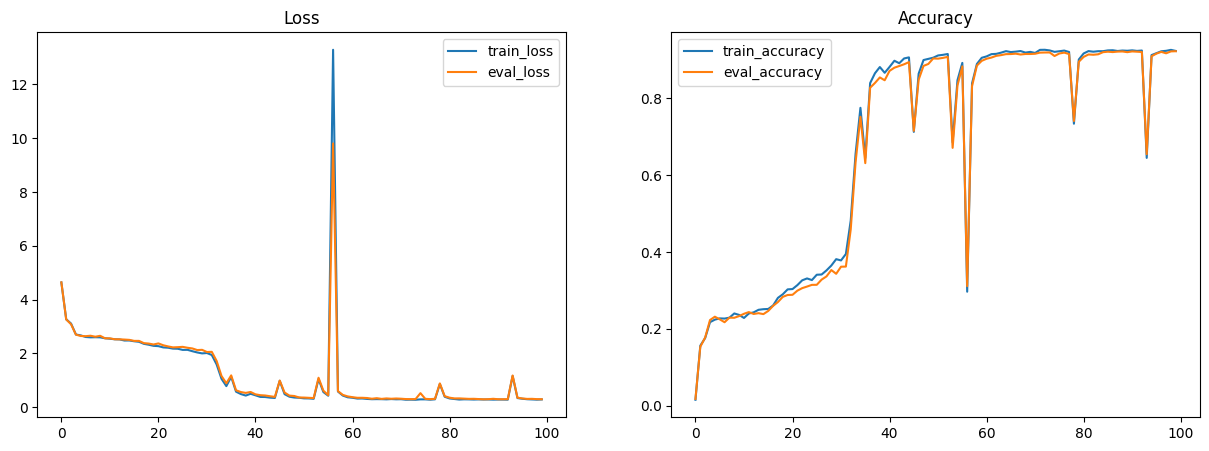

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [30]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, var_params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = model.apply({'params': params, **var_params}, context, training=False, mutable=['other_variables'])[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -n_tokens, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [31]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, var_params, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 21, 27, 24, 15, 33, 31, 10, 0, 27, 6, 1, 50, 53, 52, 42, 5, 42, 1, 57, 46, 53, 59, 50, 42, 1, 47, 52, 1, 41, 53, 50, 42, 1, 46, 39, 60, 43, 1, 21, 56, 43, 43, 39, 57, 2, 0, 0, 18, 32, 17, 33, 21, 15, 20, 10, 0, 32, 46, 43, 1, 50, 63, 56, 52, 1, 57, 53, 8, 0, 0, 24, 13, 30, 16, 21, 16, 13, 10, 0, 20, 53, 58, 46, 1, 61, 53, 59, 52, 41, 43, 39, 52, 1, 39, 52, 42, 1, 50, 47, 56, 46, 58, 12, 0, 0, 28, 16, 27, 33, 15, 17, 10, 0, 13, 53, 47, 42, 1, 46, 39, 58, 46, 52, 43, 1, 39, 52, 42, 1, 21, 43, 57, 63, 8, 0, 13, 52, 42, 1, 58, 46, 47, 52, 45, 1, 47, 42, 1, 58, 46, 43, 41, 49, 51, 39, 45, 43, 6, 1, 47, 52, 42, 1, 58, 46, 39, 58, 1, 39, 54, 47, 53, 56, 1, 46, 39, 42, 1, 39, 56, 52, 39, 58, 43, 42, 1, 40, 59, 53, 52, 57, 1, 63, 53, 59, 1, 53, 44, 1, 47, 52, 45, 1, 42, 59, 58, 1, 51, 59, 52, 41, 59, 58, 43, 42, 6, 1, 44, 53, 59, 52, 57, 43, 1, 58, 53, 1, 39, 56, 56, 43, 6, 1, 53, 59, 56, 57, 50, 43, 1, 58, 53, 50, 6, 0, 13, 1, 54, 39, 42, 43, 1, 40, 46, 53, 52, 1, 59, 47, 56, 46, 6, 1, 52

In [32]:
dsfsdhfgjdg hfdgjdgjgfjhs'####################

SyntaxError: unterminated string literal (detected at line 1) (2630675753.py, line 1)

In [ ]:
var_params['other_variables']['Mamba_0']['hidden_state'].shape

In [ ]:
params.keys()

In [ ]:
params['Dense_12']['kernel'].shape

In [ ]:
rngk = jax.random.PRNGKey(39)
xs, ys = get_batch(rngk, train_data)
print(xs[0])
print(ys[0])

In [ ]:
logits = model.apply({'params': params, **var_params}, xs[0].reshape((1,256)), training=False, mutable=['other_variables'])[0]
rng, rng_subkey = jax.random.split(rngk)
new_token = jax.random.categorical(
  rng_subkey, logits[:, -n_tokens, :], axis=-1, shape=(1, 1)
)
print(new_token)

In [ ]:
ys[0,-32:]

In [ ]:
logits.shape

In [ ]:
jax.nn.standardize(jnp.array([2.0,3.0,4.0]))

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), 
                         training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [ ]:
TrainState.create(

In [ ]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, 
                                rngs={"dropout": key})[0]
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [ ]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False)[0]
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [ ]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results...

      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)

    key = (jax.random.split(key)[0])

    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [ ]:

logits = fin_model.apply(fin_params, xb, training=False)[0]
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

In [ ]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)

#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)


#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [ ]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False)[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [ ]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

In [ ]:
sdgh  fs

In [ ]:
state.params

In [ ]:
!pip install mamba-ssm

In [ ]:
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def create_torch(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

In [ ]:
import selective_scan_cuda

xx, aa, bb, cc, ddelta = create_torch()
y_from_repo = selective_scan_cuda.fwd(xx.squeeze(1), ddelta.squeeze(1), aa[0].squeeze(-1).T, bb.squeeze(-2)[:, None, :, :], cc.squeeze(-2)[:, None, :, :], None, None, None, False)
y_from_repo

In [ ]:
def discretize(a, b, delta):
    da = delta * a
    a_ = jnp.exp(da)
    b_ = b * delta
    return a_, b_

def ssm(x, a, b, c, delta):
    "Jax Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdims=True))
    return h, jnp.stack(y, -1)


In [ ]:
_, y_ = ssm(xx.cpu().numpy(), aa.cpu().numpy(), bb.cpu().numpy(), cc.cpu().numpy(), ddelta.cpu().numpy())

In [ ]:
from mamba_ssm import Mamba as Mamba_T
torch_mamba = Mamba_T(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embd, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
)

In [ ]:
xm = x = rand((1, 1, n_embd, 32))
xm.shape

In [ ]:
torch_mamba(xm.squeeze(1))

In [ ]:
torch_mamba.in_proj

In [ ]:
y_mamba_repo = mamba_inner_fn()

In [ ]:
xm.squeeze(1).shape